In [1]:
%matplotlib inline
from scipy.stats import rv_continuous
import numpy as np
from numpy import exp, sqrt
from scipy.special import gamma
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import capLib as ca
import fdulib as vdf
import sys
import lmfit
from py_unsio import *
import pymc
from pymodelfit import FunctionModel1DAuto

In [2]:
simfile = "/data/halotmp/myhalo-out417-dm-rot.dens"
a="all"
uns = CunsIn(simfile,a,a,False)
bits=""         # select properties, "" means all
ok=uns.nextFrame(bits)   # load data from disk
print bool(ok),"and", uns.isValid()

True and True


In [3]:
myouputInd=1
count='00417'

vars=dict()
with open("/data/info_00417.txt") as outinfo:
    for line in outinfo:
        print(line[:-1])
        eq_index = line.find('=')
        if eq_index == -1:
            continue
        var_name = line[:eq_index].strip()
        number = float(line[eq_index + 1:].strip())
        vars[var_name] = number
        if var_name == "unit_t":
            break   


#print(vars)
print("\n\n")
aexp=vars["aexp"]
print('aexp= ',aexp)
Msunkg = 1.99844*10**30
pctocm = 3.08567758*10**18
cmtopc = 1/pctocm
unitl=vars["unit_l"]/(3.08*10**18)*pctocm
unitd=vars["unit_d"]/(pctocm/(3.08*10**18))**3
unitt=vars["unit_t"]
simutokpc=unitl/pctocm/1000
simutoMsun=(unitd*unitl**3)/1000/Msunkg
unitsimutoMsunkpc3=unitd*pctocm**3/1000/Msunkg
unitsimutokms = unitl/10**5/unitt
print "unitsimutokms", unitsimutokms
print "simutokpc= ",simutokpc
print "simutoMsun= ",simutoMsun
print 'unitsimutoMsunkpc3 =',unitsimutoMsunkpc3


Halovelx=-17.99402546833644
Halovely=-50.12026991953947
Halovelz=-66.99018276193101

ncpu        =        120
ndim        =          3
levelmin    =          7
levelmax    =         17
ngridmax    =    1166666
nstep_coarse=      19057
 
boxlen      =  0.100000000000000E+01
time        =  0.582164362472364E-04
aexp        =  0.100005792136371E+01
H0          =  0.703000030517578E+02
omega_m     =  0.275999993085861E+00
omega_l     =  0.723999977111816E+00
omega_k     =  0.298023223876953E-07
omega_b     =  0.450000017881393E-01
unit_l      =  0.613406804919268E+26
unit_d      =  0.256390627695012E-29
unit_t      =  0.438173068593696E+18



('aexp= ', 1.00005792136371)
unitsimutokms 1402.49957094
simutokpc=  19915.8053545
simutoMsun=  2.96112540644e+14
unitsimutoMsunkpc3 = 3.74854890602e-08


In [4]:
ok,pos = uns.getArrayF(a,"pos")
print bool(ok)
pos = pos * simutokpc
ok,vel = uns.getArrayF(a,"vel")
print bool(ok)
vel = vel * unitsimutokms
uns.close()
print a

True
True
all


In [5]:

x,y,z=pos[0::3],pos[1::3],pos[2::3]
vx,vy,vz=vel[0::3]-Halovelx, vel[1::3]-Halovely, vel[2::3]-Halovelz

In [6]:
print np.max(abs(z))

319.475


In [7]:
R = np.sqrt((x**2)+(y**2))
r = np.sqrt((x**2)+(y**2)+(z**2))
v = np.sqrt((vx**2) + (vy**2) + (vz**2))
print np.min(R)

0.00786856


In [8]:

shell_cond = (r<=8.5)&(r>=7.5) 
ring_cond = (r<=8.5)&(abs(z)<=.5)&(r>=7.5)
v_shell = v[shell_cond]
v_ring = v[ring_cond]
print len(v_shell)
print "max =", np.max(v_shell),"min =", np.min(v_shell)


print "n_halo =", len(r),"n_shell =", len(v_shell), "n_ring =", len(v_ring)




32669
max = 538.534 min = 8.96233
n_halo = 2839680 n_shell = 32669 n_ring = 2872


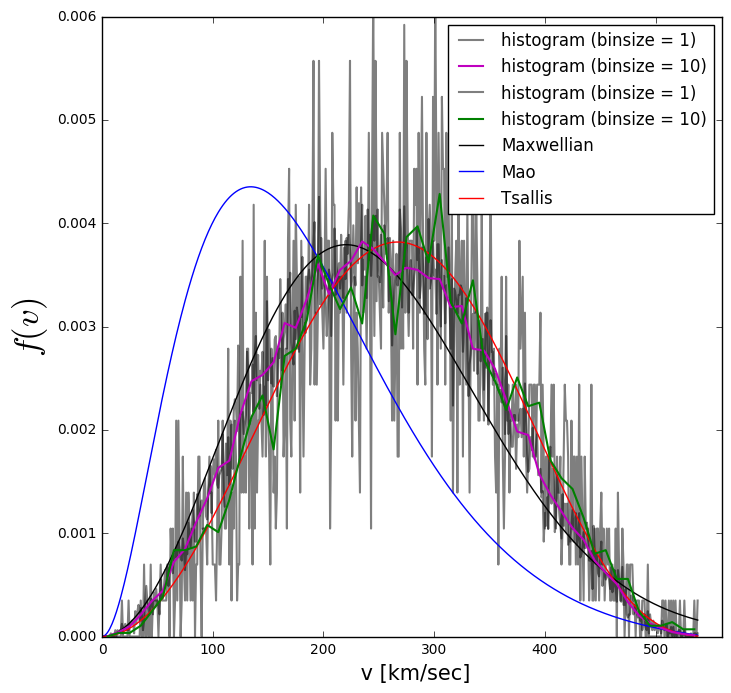

In [9]:
bin_size = 10.
v_array = np.arange(0,np.max(v_shell)+bin_size,bin_size)
hist, bins = np.histogram(v_shell,bins=v_array)
v_array_2 = np.arange(0,np.max(v_shell)+1)
hist2, bins2 = np.histogram(v_shell,bins=v_array_2)

ring_bin = np.arange(0,np.max(v_ring)+bin_size,bin_size)
histr, binsr = np.histogram(v_ring,bins=ring_bin)
ring_bin2 = np.arange(0,np.max(v_ring)+1)
hist2r, bins2r = np.histogram(v_ring,bins=ring_bin2)


x_array = [i for i in np.arange(0.1,np.max(v_shell))]
SHM = map(vdf.shm_gal, x_array)
MAO = map(vdf.mao_gal,x_array)
LIN = map(vdf.lin_gal,x_array)


fig,ax = plt.subplots(figsize=[8,8])
ax.set_xlabel(" v [km/sec]",fontsize=15)
ax.set_ylabel(r'$f(v)$',fontsize=25)

ax.set_ylim([0,0.006])
ax.set_xlim([0,560])
ax.plot(bins2[:-1],hist2/float(len(v_shell)),color='k',linewidth=1.5,alpha=.5,
        label = 'histogram (binsize = 1)')
ax.plot(bins[:-1]+(bin_size/2),hist/float(len(v_shell)*bin_size),'m',zorder=10,
        linewidth=1.5,label = 'histogram (binsize = 10)')

ax.plot(bins2r[:-1],hist2r/float(len(v_ring)),color='k',linewidth=1.5,alpha=.5,
        label = 'histogram (binsize = 1)')
ax.plot(binsr[:-1]+(bin_size/2),histr/float(len(v_ring)*bin_size),'g',zorder=10,
        linewidth=1.5,label = 'histogram (binsize = 10)')


ax.plot(x_array, SHM,'k-',label = "Maxwellian")
ax.plot(x_array, MAO,'b-', label = "Mao")
ax.plot(x_array, LIN,'r-',label = "Tsallis")
legend = ax.legend(loc='upper right', shadow=False)
frame = legend.get_frame()

In [10]:
%%latex
so now well change the coordinates system into a cylindrical coordinate system in the form

\begin{equation}
x=\rho\cos{\theta}
\end{equation}
\begin{equation}
y=\rho\sin{\theta}
\end{equation}

where $\rho = \sqrt{x^2+y^2}$ and therefore we can define the other cylindrical coordinates as:
    
\begin{equation}
z=z
\end{equation}
\begin{equation}
\theta = \arcsin{\left(\frac{y}{\rho}\right)} = \arccos{\left(\frac{x}{\rho}\right)}
=\arctan{\left(\frac{y}{x}\right)}
\end{equation}


and thus the velocities take the form:
    
\begin{equation}
v_{\rho}=\cos{\theta}v_x +\sin{\theta}v_y
\end{equation}
and the velocity in $\theta$

\begin{equation}
v_{\theta} = \frac{\cos{\theta}v_y -\sin{\theta}v_x}{\rho}
\end{equation}

    

<IPython.core.display.Latex object>

In [11]:

vx_shl, vy_shl = vx[shell_cond], vy[shell_cond]


## CYLINDIRCAL


phi = np.zeros(len(r)) 
phi[(x>0)]=np.arctan(y[(x>0)]/x[(x>0)])
phi[(x<0)]=-np.arcsin(y[(x<0)]/R[(x<0)])+np.pi
theta = np.arccos(z / r)
#phi=np.arcsin(y/R)
print len(phi)


print "phi_max =", max(phi) / np.pi, "phi_min =", min(phi)/np.pi, "full phi=", (abs(min(phi))+max(phi)) / np.pi


#vR = -((np.cos(phi)*vx)+(np.sin(phi)*vy))
#vphi = ((-np.cos(phi)*vx)+(np.sin(phi)*vy))

#vR = (vx*np.cos(phi)+vy*np.sin(phi))
vR = (vx*x + vy*y)/ R
vr = (vx*x + vy*y + vz*z)/ r
#vphi = (vy*np.cos(phi)+vx*np.sin(phi))
vphi = (-vx*y + vy*x )/ R

print "vr_max",np.max(vr),"vr_min", np.min(vr)

vr_shell = vr[shell_cond]
vR_shell = vR[shell_cond]

vphi_shell = vphi[shell_cond]
vz_shell = vz[shell_cond]
print "vr_max_shell",np.max(vr_shell),"vr_min_shell", np.min(vr_shell)
vR_ring = vR[ring_cond]
vr_ring = vr[ring_cond]
vphi_ring = vphi[ring_cond]
vz_ring = vz[ring_cond]

print "n_halo =", len(vz),"n_shell =", len(vz_shell), "n_ring =", len(vphi_ring)



2839680
phi_max = 1.5000000038 phi_min = -0.499999406786 full phi= 1.99999941058
vr_max 573.958 vr_min -562.307
vr_max_shell 480.321 vr_min_shell -509.679
n_halo = 2839680 n_shell = 32669 n_ring = 2872


<Container object of 59 artists>

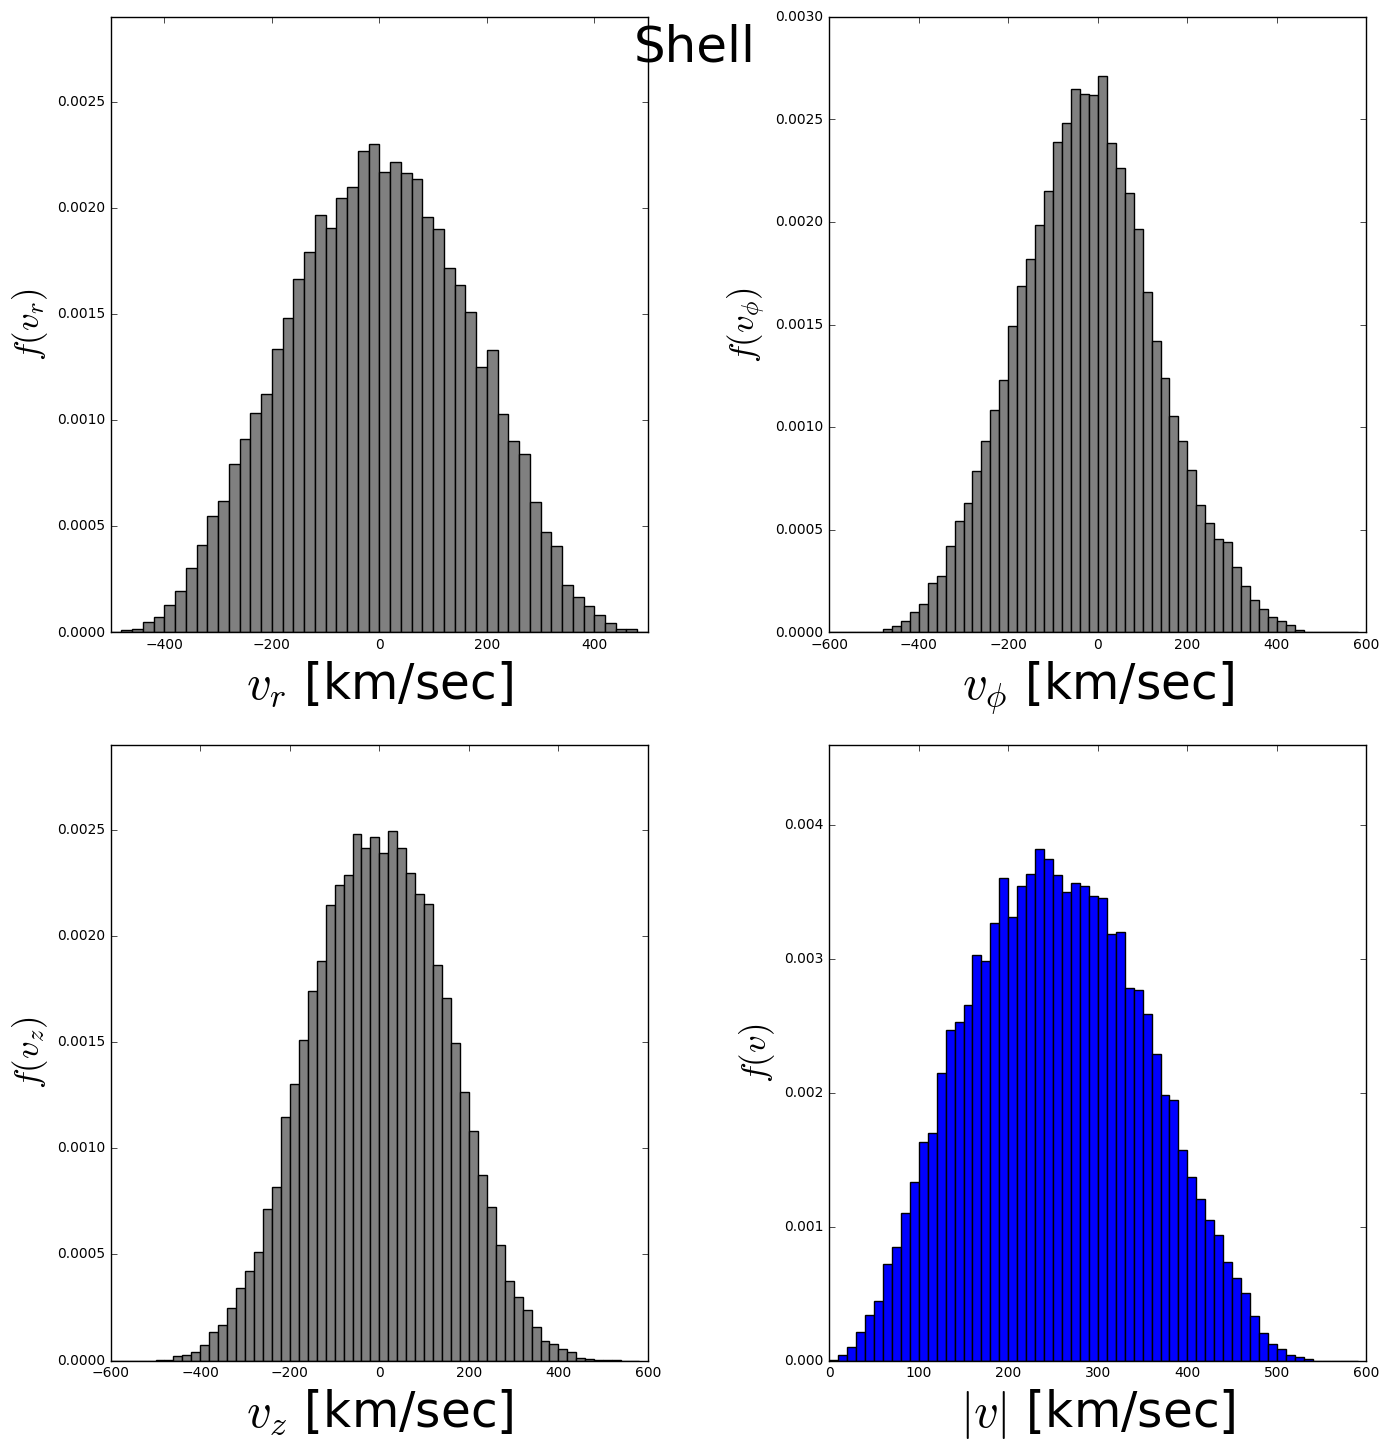

In [12]:
fig,((ax,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=[14,14])
fig.tight_layout(w_pad=5.5)
fig.subplots_adjust(top=3.88)
fig.suptitle("Shell", size=36)
ax.set_xlabel(r'$v_r$ [km/sec]',fontsize=35)
ax.set_ylabel(r'$f(v_r)$',fontsize=25)
ax.set_xlim([-500,500])
ax3.set_xlim([0,600])
ax.set_ylim([0,29e-4])
ax1.set_ylim([0,30e-4])
ax2.set_ylim([0,29e-4])
ax3.set_ylim([0,46e-4])

bin_array = np.arange(-600,600,20)
vR_Hist_shell = np.histogram(vR_shell,bins=bin_array,normed=1)
ax.bar(vR_Hist_shell[1][:-1],vR_Hist_shell[0], width=20,
        color='gray')

#ax.plot(testx,myDoubleGaussianFunc(testx,popt[0],popt[1],popt[2],popt[3]))
ax1.set_xlabel(r'$v_{\phi}$ [km/sec]',fontsize=35)
ax1.set_ylabel(r'$f(v_{\phi})$',fontsize=25)

fig.tight_layout(w_pad=5.5, h_pad=2.0)
vphi_Hist_shell = np.histogram(vphi_shell,bins=bin_array,normed=1)
ax1.bar(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0], width=20,
        color='gray')
#fig, (ax,ax1) = plt.subplots(1,2,figsize=[13,6])
#plt.tight_layout(w_pad=5.5, h_pad=1.0)
ax2.set_xlabel(r'$v_z$ [km/sec]',fontsize=35)
ax2.set_ylabel(r'$f(v_z)$',fontsize=25)
ax3.set_xlabel(r'$|v|$ [km/sec]',fontsize=35)
ax3.set_ylabel(r'$f(v)$',fontsize=25)

vz_Hist_shell = np.histogram(vz_shell,bins=bin_array,normed=1)
ax2.bar(vz_Hist_shell[1][:-1],vz_Hist_shell[0], width=20,
        color='gray')

bin_array2 = np.arange(0,600,10)
vmod_Hist_shell = np.histogram(v_shell,bins=bin_array2,normed=1)
ax3.bar(vmod_Hist_shell[1][:-1],vmod_Hist_shell[0], width=10,
        color='blue')



<Container object of 27 artists>

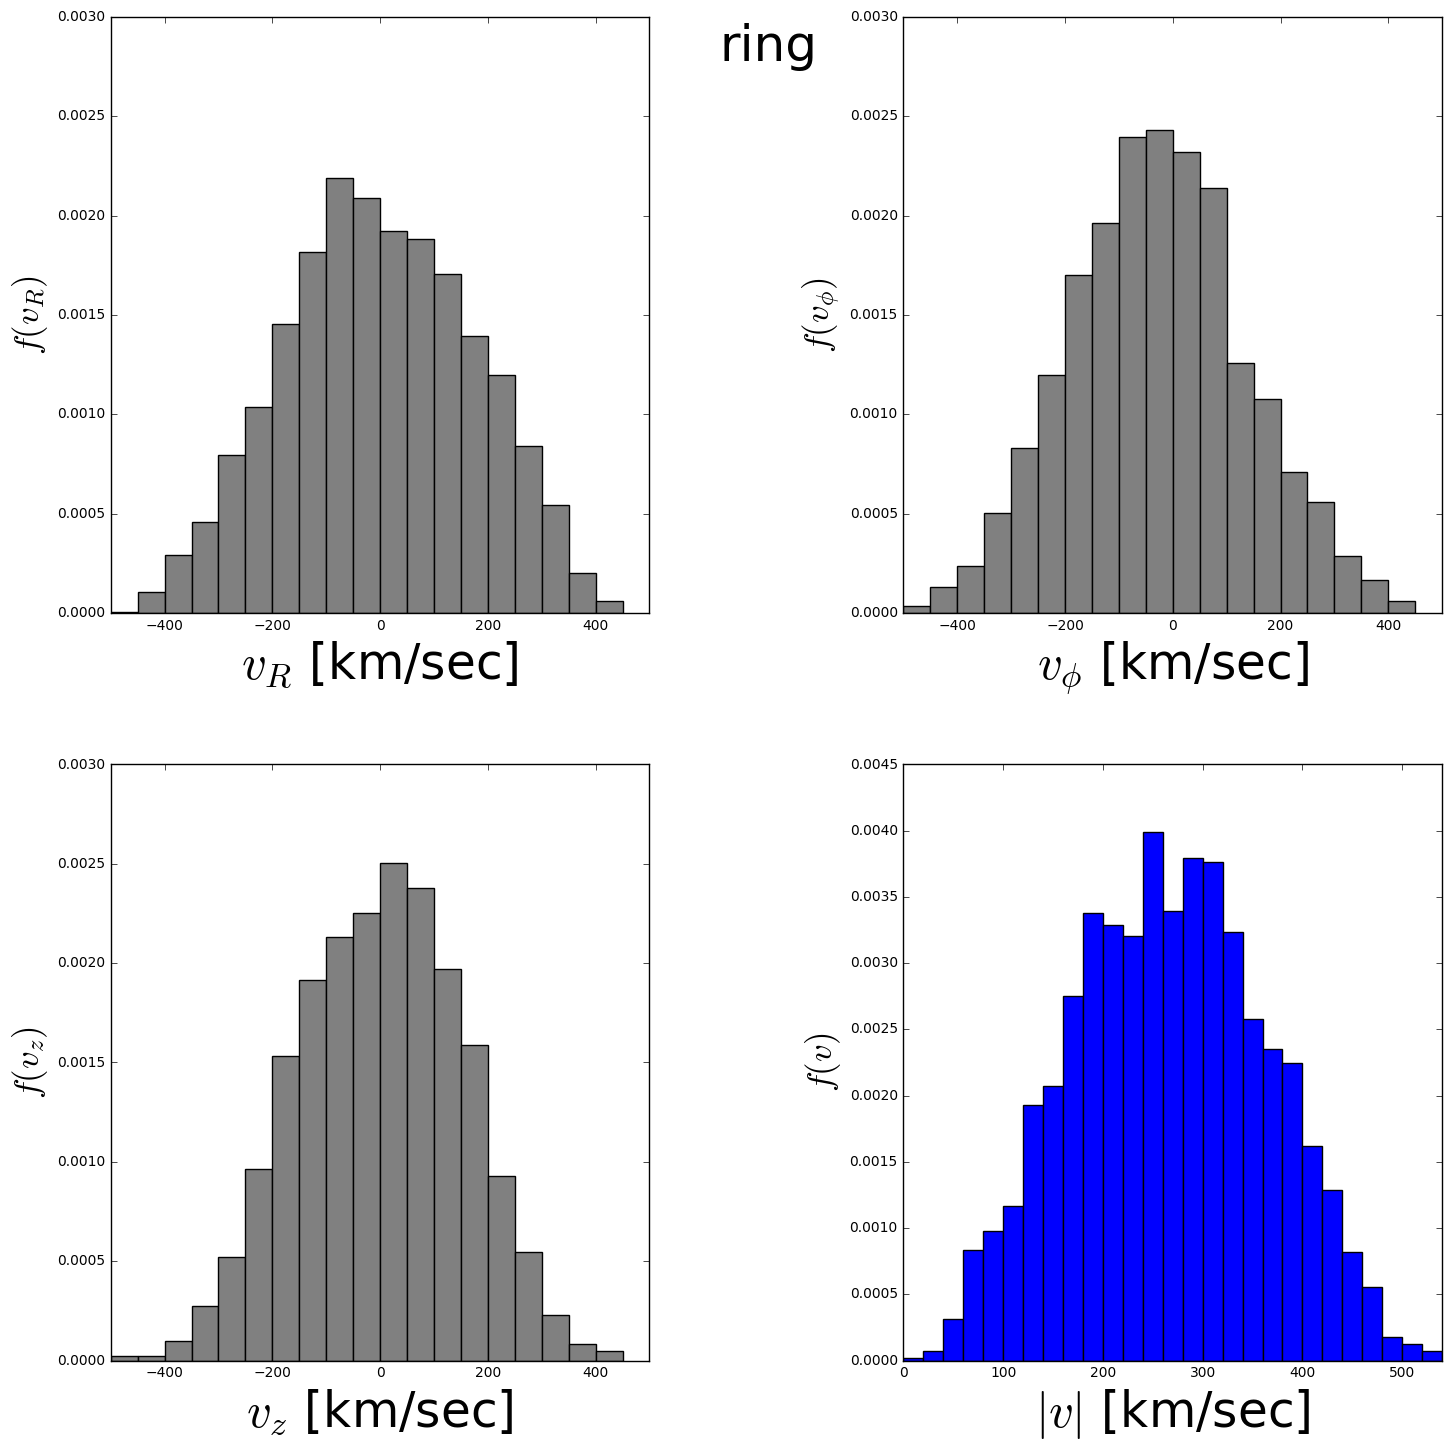

In [13]:
fig,((ax,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=[14,14])
#fig.tight_layout(h_pad=8,w_pad=5.5)
fig.subplots_adjust(top=3.88)
fig.suptitle("ring", size=36)
fig.tight_layout(w_pad=15.5, h_pad=9.0)

ax.set_xlabel(r'$v_R$ [km/sec]',fontsize=35)
ax.set_ylabel(r'$f(v_R)$',fontsize=25)
ax.set_xlim([-500,500])
ax.set_ylim([0,0.003])
bin_array = np.arange(-500,500,50)
bin_array2 = np.arange(-500,500,10)
vR_Hist_ring = np.histogram(vR_ring,bins=bin_array,normed=1)

ax.bar(vR_Hist_ring[1][:-1],vR_Hist_ring[0], width=50, color='gray')


ax1.set_xlabel(r'$v_{\phi}$ [km/sec]',fontsize=35)
ax1.set_ylabel(r'$f(v_{\phi})$',fontsize=25)
ax1.set_xlim([-500,500])
ax1.set_ylim([0,0.003])
vphi_Hist_ring = np.histogram(vphi_ring,bins=bin_array,normed=1)
ax1.bar(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0], width=50,
        color='gray')


ax2.set_xlim([-500,500])
ax2.set_ylim([0,0.003])
ax2.set_xlabel(r'$v_z$ [km/sec]',fontsize=35)
ax2.set_ylabel(r'$f(v_z)$',fontsize=25)
ax3.set_xlabel(r'$|v|$ [km/sec]',fontsize=35)
ax3.set_ylabel(r'$f(v)$',fontsize=25)

ax3.set_xlim([0,540])
ax3.set_ylim([0,0.0045])
vz_Hist_ring = np.histogram(vz_ring,bins=bin_array,normed=1)
ax2.bar(vz_Hist_ring[1][:-1],vz_Hist_ring[0], width=50,
        color='gray')


bin_array_mod = np.arange(0,550,20)
vmod_Hist_ring = np.histogram(v_ring,bins=bin_array_mod,normed=1)
ax3.bar(vmod_Hist_ring[1][:-1],vmod_Hist_ring[0], width=20,
        color='blue')



In [78]:
def myGaussian(x,mu,v0):
    alpha = 1.
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)

def myDoubleGaussianFunc(x,frac,v01,mu2,v02):
    return np.sqrt(frac)*myGaussian(x,0,v01)+(1-np.sqrt(frac))*myGaussian(x,mu2,v02)

def myChi2(obs,exp,dof):
    return np.sum((obs-exp)**2/exp/dof,dtype=np.float64)

def myGenGaussian(x,mu,v0,alpha):
    n = 2 * v0 * gamma(1+(1/(2*alpha)))
    return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)

def myGenMaxwellian(x,v0,alpha):
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

def myMaxwellian(x,v0):
    alpha = 1.
    n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
    return (x**2/n) * np.exp(-(x/v0)**(2*alpha))

def maosDistribution(x,v0,p):
    v_esc =541.
    term = ((v_esc**2) - (x**2))**p
    if x < v_esc and x > 0: 
        return (x**2) * np.exp(-x/v0) * term
    else:
        return 0

## Fitting section

In [79]:
class MyGaussianModel(FunctionModel1DAuto):
    def f(self,x,mu=.1,v0=200):
        alpha = 1.
        n = 2 * v0 *gamma(1+(1/(2*alpha)))
        return (1/n) * np.exp(-((x-mu)**2/(v0**2))**alpha)
        
class MyDoubleGaussianModel(FunctionModel1DAuto):
    def f(self,x,frac=0.5,v01=100,mu2=.1,v02=200):
        return np.sqrt(frac)*myGaussian(x,mu2,v01)+((1-np.sqrt(frac))*myGaussian(x,0,v02))

#class MyDoubleGaussianModel(FunctionModel1DAuto):
#    def f(self,x,frac=0.5,v01=100,mu2=.1,v02=200):
#        return myDoubleGaussianFunc(x,frac,v01,mu2,v02)
        

class MyGenGaussianModel(FunctionModel1DAuto):
    def f(self,x,mu=.1,v0=200.,alpha=1.3):
        n = 2. * v0 * gamma(1.+(1./(2*alpha)))
        return (1./n) * np.exp(-((x-mu)**2/(v0**2))**alpha)
    
class MyGenMaxwellianModel(FunctionModel1DAuto):
    def f(self, x, v0=300.,alpha=1.5):
        n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
        return (x**2/n) * np.exp(-(x/v0)**(2*alpha))
    
class MyMaxwellianModel(FunctionModel1DAuto):
    def f(self, x, v0=250.):
        alpha = 1.
        n = v0**3 * gamma(1. + (3./(2.*alpha))) / 3.
        return (x**2/n) * np.exp(-(x/v0)**(2*alpha))
    
class MaoModel(FunctionModel1DAuto):
    def f(self,x,v0=300.,p=2.):
        v_esc =541.
        term = ((v_esc**2) - (x**2))**p
        return (x**2) * np.exp(-x/v0) * term
#        return (x**2) * np.exp(-x/v0) * term

def myChi2(obs, expected):
    return np.sum((obs-expected)**2/expected)

In [80]:
### Gaussian fit
myG = MyGaussianModel()
R_G_fit = myG.fitData(vR_Hist_ring[1][:-1]+25,vR_Hist_ring[0])
phi_G_fit = myG.fitData(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0])
z_G_fit = myG.fitData(vz_Hist_ring[1][:-1]+25,vz_Hist_ring[0])
print "chi", len(v_ring)*myChi2(vz_Hist_ring[0],myGaussian(vz_Hist_ring[1][:-1]+25,z_G_fit[0],z_G_fit[1]))
### Double Gaussian
myDoubleG = MyDoubleGaussianModel()
R_DG_fit = myDoubleG.fitData(vR_Hist_ring[1][:-1],vR_Hist_ring[0])
phi_DG_fit = myDoubleG.fitData(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0])
z_DG_fit = myDoubleG.fitData(vz_Hist_ring[1][:-1],vz_Hist_ring[0])

### Generalized Gaussian
myGeneralG = MyGenGaussianModel()
R_GG_fit = myGeneralG.fitData(vR_Hist_ring[1][:-1]+25,vR_Hist_ring[0])
phi_GG_fit = myGeneralG.fitData(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0])
z_GG_fit = myGeneralG.fitData(vz_Hist_ring[1][:-1]+25,vz_Hist_ring[0])

####### fit to the modulus distributions #######
### Maxwellian
myMax = MyMaxwellianModel()
v_M_fit = myMax.fitData(vmod_Hist_ring[1][:-1],vmod_Hist_ring[0])
### Generalized Maxwellian
myGenMax = MyGenMaxwellianModel()
v_GM_fit = myGenMax.fitData(vmod_Hist_ring[1][:-1],vmod_Hist_ring[0])
### Mao



chi 0.696370533597


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in sqrt


In [81]:
fig,((ax,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=[14,14])
#fig.tight_layout(h_pad=8,w_pad=5.5)
fig.subplots_adjust(top=3.88)
fig.suptitle("ring", size=36)
fig.tight_layout(w_pad=15.5, h_pad=9.0)

ax.set_xlabel(r'$v_R$ [km/sec]',fontsize=35)
ax.set_ylabel(r'$f(v_R)$',fontsize=35)
ax.set_xlim([-500,500])
ax.set_ylim([0,0.003])
bin_array = np.arange(-500,500,50)
vR_Hist_ring = np.histogram(vR_ring,bins=bin_array,normed=1)

ax.bar(vR_Hist_ring[1][:-1],vR_Hist_ring[0], width=50, color='gray')
v_test = np.arange(-525,525)

ax.plot(v_test, myGaussian(v_test,R_G_fit[0],R_G_fit[1]),
        linewidth = 2)
ax.plot(v_test, myGenGaussian(v_test,R_GG_fit[0],R_GG_fit[1],
                              R_GG_fit[2]),linewidth = 2)

#### uncoment if need to plot double gaussian fit
#ax.plot(v_test, myDoubleGaussianFunc(v_test,R_DG_fit[0],R_DG_fit[1],
#                                     R_DG_fit[2],R_DG_fit[3]))
#######################################################
ax1.set_xlabel(r'$v_{\phi}$ [km/sec]',fontsize=35)
ax1.set_ylabel(r'$f(v_{\phi})$',fontsize=35)
ax1.set_xlim([-500,500])
ax1.set_ylim([0,0.003])

vphi_Hist_ring = np.histogram(vphi_ring,bins=bin_array,normed=1)
ax1.bar(vphi_Hist_ring[1][:-1],vphi_Hist_ring[0], width=50,
        color='gray',align='center')

ax1.plot(v_test,phi_DG_fit[0]*myGaussian(v_test,phi_DG_fit[2],
                                  phi_DG_fit[1]),linewidth = 2)
ax1.plot(v_test, (1-phi_DG_fit[0])*myGaussian(v_test,0,phi_DG_fit[3]),
        linewidth = 2)
print phi_DG_fit
ax1.plot(v_test-25., myDoubleGaussianFunc(v_test,phi_DG_fit[0],
                                      phi_DG_fit[1],phi_DG_fit[2],
                                      phi_DG_fit[3]),linewidth = 2)


ax2.set_xlim([-500,500])
ax2.set_ylim([0,0.003])
ax2.set_xlabel(r'$v_z$ [km/sec]',fontsize=35)
ax2.set_ylabel(r'$f(v_z)$',fontsize=35)
ax3.set_xlabel(r'$|v|$ [km/sec]',fontsize=35)
ax3.set_ylabel(r'$f(v)$',fontsize=35)



ax3.set_xlim([0,540])
ax3.set_ylim([0,0.0045])
vz_Hist_ring = np.histogram(vz_ring,bins=bin_array,normed=1)
ax2.bar(vz_Hist_ring[1][:-1],vz_Hist_ring[0], width=50,
        color='gray')

ax2.plot(v_test, myGaussian(v_test,z_G_fit[0],z_G_fit[1]),linewidth=1.7)
ax2.plot(v_test, myGenGaussian(v_test,z_GG_fit[0],z_GG_fit[1],
                              z_GG_fit[2]),linewidth = 2)

#ax2.plot(v_test, myDoubleGaussianFunc(v_test,z_DG_fit[0],z_DG_fit[1],
#                                     z_DG_fit[2],z_DG_fit[3]))

bin_array_mod = np.arange(0,550,20)
vmod_Hist_ring = np.histogram(v_ring,bins=bin_array_mod,normed=1)
ax3.bar(vmod_Hist_ring[1][:-1],vmod_Hist_ring[0], width=20,
        color='blue')

mod_test = np.arange(0,550)
ax3.plot(mod_test, myMaxwellian(mod_test,v_M_fit[0]),'k-',linewidth=2)
ax3.plot(mod_test, myGenMaxwellian(mod_test,v_GM_fit[0],v_GM_fit[1]),'r-',linewidth=2)


[  1.21643877e-12  -5.11072368e+06  -1.22869382e+08   2.48290013e+02]


In [73]:
### Gaussian fit
myG = MyGaussianModel()
R_G_fit = myG.fitData(vR_Hist_shell[1][:-1]+10,vR_Hist_shell[0])
phi_G_fit = myG.fitData(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0])
z_G_fit = myG.fitData(vz_Hist_shell[1][:-1]+10,vz_Hist_shell[0])
print "chi", len(v_shell)*myChi2(vz_Hist_shell[0],
                                 myGaussian(vz_Hist_shell[1][:-1]+25,
                                            z_G_fit[0],z_G_fit[1]))

### Double Gaussian
myDoubleG = MyDoubleGaussianModel()
R_DG_fit = myDoubleG.fitData(vR_Hist_shell[1][:-1]+10,vR_Hist_shell[0])
phi_DG_fit = myDoubleG.fitData(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0])
z_DG_fit = myDoubleG.fitData(vz_Hist_shell[1][:-1]+10,vz_Hist_shell[0])
print phi_DG_fit

### Generalized Gaussian
myGeneralG = MyGenGaussianModel()
R_GG_fit = myGeneralG.fitData(vR_Hist_shell[1][:-1]+10,vR_Hist_shell[0])
phi_GG_fit = myGeneralG.fitData(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0])
z_GG_fit = myGeneralG.fitData(vz_Hist_shell[1][:-1]+10,vz_Hist_shell[0])

####### fit to the modulus distributions #######
### Maxwellian
myMax = MyMaxwellianModel()
v_M_fit = myMax.fitData(vmod_Hist_shell[1][:-1],vmod_Hist_shell[0])
### Generalized Maxwellian
myGenMax = MyGenMaxwellianModel()
v_GM_fit = myGenMax.fitData(vmod_Hist_shell[1][:-1],vmod_Hist_shell[0])
### Mao

chi 27.418751698
[  1.20398911e-06  -3.49212628e+07   4.25642976e-01   2.36959693e+02]


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in sqrt


In [74]:
fig,((ax,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=[14,14])
#fig.tight_layout(h_pad=8,w_pad=5.5)
fig.subplots_adjust(top=3.88)
fig.suptitle("shell", size=36)
fig.tight_layout(w_pad=15.5, h_pad=9.0)

ax.set_xlabel(r'$v_R$ [km/sec]',fontsize=35)
ax.set_ylabel(r'$f(v_R)$',fontsize=35)
ax.set_xlim([-500,500])
ax.set_ylim([0,0.003])


ax.bar(vR_Hist_shell[1][:-1],vR_Hist_shell[0], width=20, color='gray')
v_test = np.arange(-525,525)

ax.plot(v_test, myGaussian(v_test,R_G_fit[0],R_G_fit[1]),
        linewidth = 2)
ax.plot(v_test, myGenGaussian(v_test,R_GG_fit[0],R_GG_fit[1],
                              R_GG_fit[2]),linewidth = 2)

#### uncoment if need to plot double gaussian fit
#ax.plot(v_test, myDoubleGaussianFunc(v_test,R_DG_fit[0],R_DG_fit[1],
#                                     R_DG_fit[2],R_DG_fit[3]))
#######################################################
ax1.set_xlabel(r'$v_{\phi}$ [km/sec]',fontsize=35)
ax1.set_ylabel(r'$f(v_{\phi})$',fontsize=35)
ax1.set_xlim([-500,500])
#ax1.set_ylim([0,0.003])


#ax1.bar(vphi_Hist_shell[1][:-1],vphi_Hist_shell[0], width=20,
#        color='gray',align='center')

ax1.plot(v_test,phi_DG_fit[0]*myGaussian(v_test,phi_DG_fit[2],
                                  phi_DG_fit[1]),linewidth = 2)
ax1.plot(v_test, (1-phi_DG_fit[0])*myGaussian(v_test,0,phi_DG_fit[3]),
        linewidth = 2)
print phi_DG_fit
#ax1.plot(v_test, myDoubleGaussianFunc(v_test,phi_DG_fit[0],
#                                      phi_DG_fit[1],phi_DG_fit[2],
#                                      phi_DG_fit[3]), 'k',linewidth = 2)


ax2.set_xlim([-500,500])
ax2.set_ylim([0,0.003])
ax2.set_xlabel(r'$v_z$ [km/sec]',fontsize=35)
ax2.set_ylabel(r'$f(v_z)$',fontsize=35)
ax3.set_xlabel(r'$|v|$ [km/sec]',fontsize=35)
ax3.set_ylabel(r'$f(v)$',fontsize=35)



ax3.set_xlim([0,540])
ax3.set_ylim([0,0.0045])
ax2.bar(vz_Hist_shell[1][:-1],vz_Hist_shell[0], width=20,
        color='gray')

ax2.plot(v_test, myGaussian(v_test,z_G_fit[0],z_G_fit[1]),linewidth=1.7)
ax2.plot(v_test, myGenGaussian(v_test,z_GG_fit[0],z_GG_fit[1],
                              z_GG_fit[2]),linewidth = 2)

#ax2.plot(v_test, myDoubleGaussianFunc(v_test,z_DG_fit[0],z_DG_fit[1],
#                                     z_DG_fit[2],z_DG_fit[3]))


ax3.bar(vmod_Hist_shell[1][:-1],vmod_Hist_shell[0], width=10,
        color='blue')

mod_test = np.arange(0,550)
ax3.plot(mod_test, myMaxwellian(mod_test,v_M_fit[0]),'k-',linewidth=2)
ax3.plot(mod_test, myGenMaxwellian(mod_test,v_GM_fit[0],v_GM_fit[1]),'r-',linewidth=2)


[  1.20398911e-06  -3.49212628e+07   4.25642976e-01   2.36959693e+02]


In [ ]:
scipy.special.gamma(3)

#### 